In [1]:
from tensorflow.keras.models import load_model
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import os
from pathlib import Path
from tensorflow.keras import mixed_precision
import transformers
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate, Dense
import pickle


# enable tf debugging
# tf.debugging.experimental.enable_dump_debug_info('./logs_tfboard/tfds_dumps/', tensor_debug_mode="FULL_HEALTH")


# stop tf from using all gpu memory and use only as much required
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)


2023-02-04 08:28:47.548604: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-02-04 08:28:49.265180: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-02-04 08:28:49.671659: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: NVIDIA A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-02-04 08:28:49.671712: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-02-04 08:28:49.676619: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-02-04 08:28:49.676717: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas

In [2]:
import tensorflow.keras.backend as k


def mean_acc(y_true, y_pred):
    diff = k.abs(y_true - y_pred)
    return k.mean(1-diff)

# load all model embeddings/ defining multimodal (4 models)

## Uncomment below codes to change multimodal architechture

In [3]:
model_env = load_model(
    "/mount1/harish/Personality_trait/checkpoint/00004-env_personality/env-personality-model-04-0.12.h5",
    custom_objects={"mean_acc": mean_acc}
                  )

2023-02-04 08:28:50.047496: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-04 08:28:50.100675: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: NVIDIA A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-02-04 08:28:50.104742: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0
2023-02-04 08:28:50.104836: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-02-04 08:28:52.507576: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnec

In [4]:
# # Save frame model 
# model.save("env_personality.h5")

In [5]:
model_face = load_model(
    "/mount1/harish/Personality_trait/checkpoint/face_personality/00008-face_personality/face-personality-model-05-0.12.h5", 
    custom_objects = {"mean_acc": mean_acc}
)

In [6]:
# # Save face model
# model_face.save("face_personality.h5")

In [7]:
model_aud = load_model("/mount1/harish/Personality_trait/checkpoint/audio_personality/00008-audio_personality/audio-personality-model-11-0.11.h5", 
                      custom_objects={"mean_acc": mean_acc})

In [8]:
# # Save audio model
# model_aud.save("audio_personality_par_model.h5")

In [9]:
# model_text = load_model(
#     "/mount1/harish/Personality_trait/checkpoint/00015-text_personality/text-personality-model-16-0.12.h5",
#     custom_objects={"mean_acc": mean_acc, "TFBertModel": transformers.TFBertModel}
# )

In [10]:
# # Save text model
# model_text.save("text_personality_ocean.h5")

In [11]:

model_path = "text_personality_ocean.h5"

custom_objects={"mean_acc": mean_acc, "TFBertModel": transformers.TFBertModel}

model_text = load_model(model_path, custom_objects=custom_objects)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: '<' not supported between instances of 'Literal' and 'str'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: '<' not supported between instances of 'Literal' and 'str'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [12]:
# Freeze all pretrained model
model_face.trainable = False
model_aud.trainable = False
model_text.trainable = False
model_env.trainable = False

## Building multimodal

In [13]:
# Create text emb model
op_txt = Dense(128, name='txt_emb')(model_text.get_layer("global_average_pooling1d").output)

model_text_emb = Model(inputs=model_text.input, outputs=op_txt)
# model_text_emb.trainable = False
model_text_emb.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 64)]         0                                            
__________________________________________________________________________________________________
masked_token (InputLayer)       [(None, 64)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_token[0][0]                
                                                                 masked_token[0][0]               
__________________________________________________________________________________________________
global_average_pooling1d (Globa (None, 768)          0           tf_bert_model[0][0]          

In [14]:
# Create frame emb model
model_env_emb = Model(inputs=model_env.input, outputs=model_env.get_layer("lstm_1").output)
# model_env_emb.trainable = False
model_env_emb.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 30, 224, 224, 3)] 0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 2048)          42626560  
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               2360320   
Total params: 44,986,880
Trainable params: 0
Non-trainable params: 44,986,880
_________________________________________________________________


In [15]:
# Create face emb model
model_face_emb = Model(inputs=model_face.input, outputs=model_face.get_layer("lstm").output)
# model_face_emb.trainable = False
model_face_emb.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 30, 224, 224, 3)] 0         
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 2048)          23564800  
_________________________________________________________________
lstm (LSTM)                  (None, 256)               2360320   
Total params: 25,925,120
Trainable params: 0
Non-trainable params: 25,925,120
_________________________________________________________________


In [16]:
# Create aud emb model
aud_op = Dense(256, name='aud_emb')(model_aud.get_layer("dense_2").output)

model_aud_emb = Model(inputs=model_aud.inputs, outputs = aud_op)
model_aud_emb.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_embedding (InputLayer) [(None, 1024)]            0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
aud_emb (Dense)              (None, 256)               131328    
Total params: 656,128
Trainable params: 131,328
Non-trainable params: 524,800
_________________________________________________________________


In [17]:
# Create multimodal
concat_inp = concatenate([model_env_emb.output, model_face_emb.output, model_aud_emb.output, model_text_emb.output])
x = Dense(512, activation="relu", name="dense_comb")(concat_inp)
x = Dense(256, activation="relu", name="dense_comb1")(x)
x = Dense(5, activation="sigmoid",  name="dense_op")(x)

model = Model(inputs=[model_env_emb.input, model_face_emb.input, model_aud_emb.input, model_text.input], outputs=x)

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 64)]         0                                            
__________________________________________________________________________________________________
masked_token (InputLayer)       [(None, 64)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 30, 224, 224 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 30, 224, 224 0                                            
____________________________________________________________________________________________

In [18]:
# # Save multimodal
# model.save("multimodal_architechture_definition.h5")

In [19]:
# # clear all models
# from tensorflow.keras.backend import clear_session
# import gc


# clear_session()
# gc.collect()

In [20]:
# # Delete all unwanted model
# del model_aud
# del model_face
# del model_text
# del model_env
# del model_aud_emb
# del model_face_emb
# del model_env_emb
# del model_text_emb

In [21]:
# Load base multimodal architechture

In [22]:
# model = tf.keras.models.load_model("multimodal_architechture_definition.h5", custom_objects={"mean_acc": mean_acc, "TFBertModel": transformers.TFBertModel})

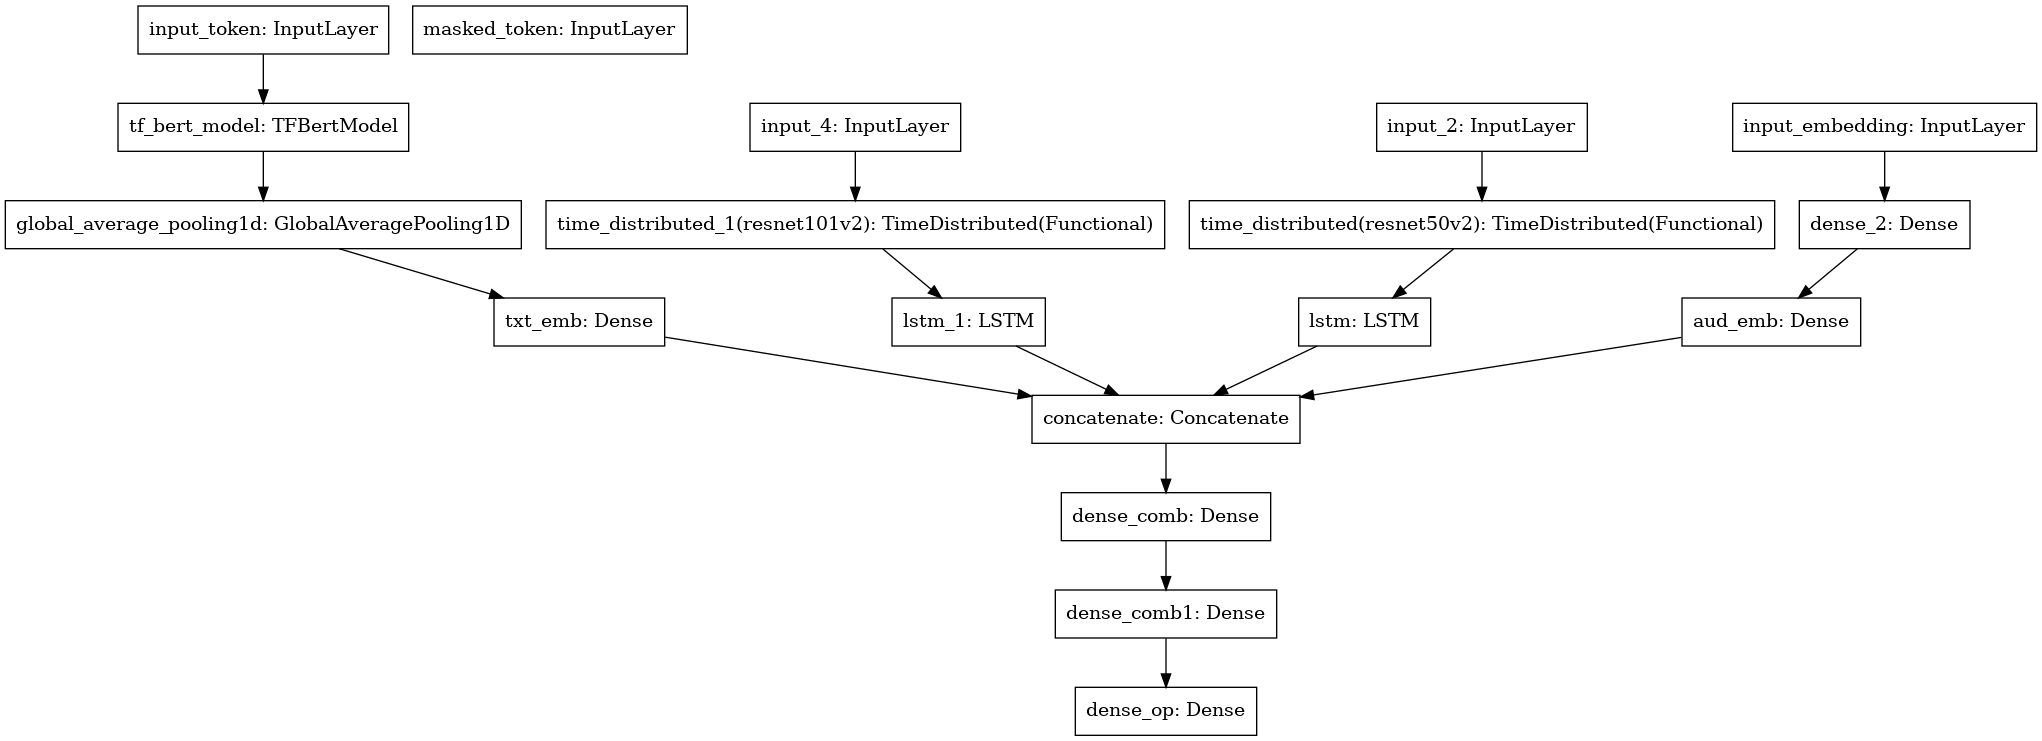

In [23]:
tf.keras.utils.plot_model(model)

In [24]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 64)]         0                                            
__________________________________________________________________________________________________
masked_token (InputLayer)       [(None, 64)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 30, 224, 224 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 30, 224, 224 0                                            
____________________________________________________________________________________________

# Audio processing

In [25]:
# Utility functions for loading audio files and making sure the sample rate is correct.
import tensorflow_io as tfio


@tf.function
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [26]:
# def load_wav_for_map1(filename, label):
#     return load_wav_16k_mono(filename)

In [27]:
import tensorflow_hub as hub


# load yamnet model
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)


# applies the embedding extraction model to a wav data
@tf.function
def extract_embedding(wav_data):
    ''' run YAMNet to extract embedding from the wav data '''
    
    file_contents = tf.io.read_file(wav_data)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav_data = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    
    scores, embeddings, spectrogram = yamnet_model(wav_data)
    print(embeddings)
    
    # embeddings = tf.math.reduce_mean(embeddings, axis=0)
    
    num_embeddings = tf.shape(embeddings)[0]
    # print(tf.shape(embeddings)[0])
    
    # use reduce mean to calculate mean of array along axis 1 (mean of column value)
    return tf.math.reduce_mean(embeddings, axis=0)


# Text processing

In [28]:
import pickle as pkl


def get_feature_tf_data(filenames):
    with open("bert_feature.pkl", 'rb') as f:
        train_feature = pkl.load(f)
    filenames = filenames.numpy().decode('utf-8')
    return np.array(train_feature[filenames]['input_ids']), np.array(train_feature[filenames]['attention_mask'])

In [29]:
# create tf dataset feature for test data

def get_feature_tf_data_test(filenames):
    with open("bert_feature_test.pkl", 'rb') as f:
        train_feature = pkl.load(f)
    filenames = filenames.numpy().decode('utf-8')
    return np.array(train_feature[filenames]['input_ids']), np.array(train_feature[filenames]['attention_mask']) 

# Video based preprocessing

In [30]:
import tensorflow as tf
import cv2


def format_frames(frame, output_size):
    """
        Pad and resize an image from a video.

        Args:
          frame: Image that needs to resized and padded. 
          output_size: Pixel size of the output frame image.

        Return:
          Formatted frame with padding of specified output size.
    """
    frame = tf.image.convert_image_dtype(frame, tf.float32)
    frame = tf.image.resize_with_pad(frame, *output_size)
    return tf.keras.applications.resnet_v2.preprocess_input(frame)
    # return frame

In [31]:
# tf dataset generator
class MetaGenerator:
    def __init__(self, df, n_frames, training = False):
        """ Returns a set of frames with their associated label. 
            Args:
                path: Video file paths.
                n_frames: Number of frames. 
                training: Boolean to determine if training dataset is being created.
        """
        self.df = df
        self.n_frames = n_frames
        self.training = training
  

    def __call__(self):
        if self.training:
            import sklearn
            self.df = sklearn.utils.shuffle(self.df)
            
        for files in self.df.itertuples():
            # video_frames = frames_from_video_file(files.file_path, self.n_frames)
            video_frames = files.file_path
            openness = files.openness
            conscientiousness = files.conscientiousness
            extraversion = files.extraversion
            agreeableness = files.agreeableness
            neuroticism = files.neuroticism
            
            label = np.array([files.openness, files.conscientiousness ,files.extraversion, files.agreeableness, files.neuroticism])
            
            yield video_frames, files.audio_path, files.filenames, label
            # return video_frames, label
            

In [32]:
from time import time
import facealignment


tools = facealignment.FaceAlignmentTools()

@tf.function
def video_audio_map(video_path, audio_path, filenames, label, n_frames, training=True,output_size = (224,224), frame_step = 15):
    """
        Creates frames from each video file present for each category.

        Args:
          video_path: File path to the video.
          audio_path: Audio file to process for embeddings
          n_frames: Number of frames to be created per video file.
          output_size: Pixel size of the output frame image.

        Return:
          An NumPy array of frames in the shape of (n_frames, height, width, channels).
    """
    # Read each video frame by frame
    result = []
    
    # face_results
    face_result = []
    
    src = cv2.VideoCapture(str(video_path))  

    video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

    need_length = 1 + (n_frames - 1) * frame_step

    if need_length > video_length:
        start = 0
    else:
        max_start = video_length - need_length
        start = random.randint(0, max_start + 1)

    src.set(cv2.CAP_PROP_POS_FRAMES, start)
    # ret is a boolean indicating whether read was successful, frame is the image itself
    ret, frame = src.read()
    if ret:
        st = time()
        
        ft_time = time()
        result.append(format_frames(frame, output_size))
        
        # align face
        face = tools.align(frame)
        
        if face is not None:
            ft_time = time()
            face_result.append(format_frames(face, output_size))
            print(f"Time for formating frame:- {time() - ft_time}")
        else:
            er_t = time()
            face_result.append(np.zeros_like(np.random.rand(224, 224, 3)))
            print(f"Append random array of req shape:- {time() - er_t}")
        
    else:
        er_t = time()
        result.append(np.zeros_like(np.random.rand(224, 224, 3)))
        
        # face result
        face_result.append(np.zeros_like(np.random.rand(224, 224, 3)))
        
    s = time()
    for _ in range(n_frames - 1):
        for _ in range(frame_step):
            ret, frame = src.read()
        if ret:
            ft_time = time()
            fr = format_frames(frame, output_size)
            result.append(fr)
            
            # for face
            face = tools.align(frame)
            # face = mtcnn(frame)
            
            if face is not None:
                ft_time = time()
                face = format_frames(face, output_size)
                face_result.append(face)
            else:
                er_t = time()
                face_result.append(np.zeros_like(np.random.rand(224, 224, 3)))

        else:
            er_t = time()
            result.append(np.zeros_like(np.random.rand(224, 224, 3)))
            face_result.append(np.zeros_like(np.random.rand(224, 224, 3)))
            
            # print(f"Append random array of req shape:- {time() - er_t}")
          
    # print(f"Time for getting aligned face from n-1 frame:- {time() - s}")
    src.release()
    if len(result) < n_frames:
        print(len(result))
    
    result = np.array(result)[..., [2, 1, 0]]
    face_result = np.array(face_result)[..., [2, 1, 0]]
    
    # audio processing
    # aud = load_wav_16k_mono(audio_path)
    aud = audio_path
    aud = extract_embedding(aud)
    
    # text processing
    if training:
        txt_inp, txt_mask = tf.py_function(get_feature_tf_data, [filenames], [tf.int64, tf.int64])
    if training == False:
        txt_inp, txt_mask = tf.py_function(get_feature_tf_data_test, [filenames], [tf.int64, tf.int64])
    return result, face_result, aud, txt_inp, txt_mask, label

# Custom checkpoint

In [33]:
import os

def generate_output_dir(outdir, run_desc):
    prev_run_dirs = []
    if os.path.isdir(outdir):
        prev_run_dirs = [x for x in os.listdir(outdir) if os.path.isdir(\
            os.path.join(outdir, x))]
    prev_run_ids = [re.match(r'^\d+', x) for x in prev_run_dirs]
    prev_run_ids = [int(x.group()) for x in prev_run_ids if x is not None]
    cur_run_id = max(prev_run_ids, default=-1) + 1
    run_dir = os.path.join(outdir, f'{cur_run_id:05d}-{run_desc}')
    assert not os.path.exists(run_dir)
    os.makedirs(run_dir)
    return run_dir

In [34]:
import re


outdir = "./checkpoint/multimodal/"
if not os.path.isdir(outdir):
    os.mkdir(outdir)

run_desc = "multimodal_personality"

run_dir = generate_output_dir(outdir, run_desc)
print(f"Results saved to: {run_dir}")

Results saved to: ./checkpoint/multimodal/00000-multimodal_personality


In [35]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


class MyModelCheckpoint(ModelCheckpoint):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    def on_epoch_end(self, epoch, logs=None):
        super().on_epoch_end(epoch,logs)

        # Also save the optimizer state
        filepath = self._get_file_path(epoch=epoch, 
                                       logs=logs, 
                                       # batch=None
                                      )

        filepath = filepath.rsplit( ".", 1 )[ 0 ] 
        filepath += ".pkl"

        with open(filepath, 'wb') as fp:
            pickle.dump(
            {
                'opt': model.optimizer.get_config(),
                'epoch': epoch+1,
                'lr': model.optimizer.learning_rate
                
             # Add additional keys if you need to store more values
            }, fp, protocol=pickle.HIGHEST_PROTOCOL)
        print('\nEpoch %05d: saving optimizaer to %s' % (epoch + 1, filepath))

In [36]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard


checkpoint = MyModelCheckpoint(os.path.join(run_dir, 'text-personality-model-{epoch:02d}-{val_loss:.2f}.h5'),
        monitor='val_loss',verbose=1, save_best_only=True, mode='auto')


# tensorboard callback to visualize progress and memory bottleneck
tboard = TensorBoard(
    log_dir='./logs_tboard/logs',
    histogram_freq=0,
    write_graph=True,
    write_images=False,
    write_steps_per_second=False,
    update_freq='epoch',
    profile_batch='500,520',
)


# reduce lr on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_mean_acc', factor=0.5, patience=2, 
                                   verbose=1, mode='min', min_lr=0.0000000001)

callbacks_list = [checkpoint, reduce_lr, tboard]

2023-02-04 08:29:11.863211: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2023-02-04 08:29:11.863238: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2023-02-04 08:29:11.864372: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1611] Profiler found 1 GPUs
2023-02-04 08:29:11.866310: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory
2023-02-04 08:29:11.883778: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcupti.so
2023-02-04 08:29:11.986361: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1661] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES
2023-02-04 08:29:11.986441: I tensorflow/core/profiler/lib/pr

# Create data

In [37]:
import pandas as pd
from tqdm import tqdm

tqdm.pandas()


def combine_all_data(split='train'):
    train_df = pd.read_csv(f"first_impression_{split}.csv")
    train_df_aud = pd.read_csv(f"first_impression_audio_{split}.csv")

    train_df_aud.drop(['extraversion', 'neuroticism', 'agreeableness', 'conscientiousness',
           'interview', 'openness', 'file'], axis=1, inplace=True)
    train_df_aud.columns = ['file_name', 'audio_path']

    train_df = train_df.merge(train_df_aud, on='file_name')

    train_text_df = pd.read_csv(f"first_impression_text_{split}_annot.csv")
    train_text_df.drop(['extraversion', 'neuroticism', 'agreeableness', 'conscientiousness',
           'interview', 'openness','file_path_video', 'file_path_audio'], axis=1, inplace=True)

    train_text_df['file_name'] = train_text_df.filenames.progress_apply(lambda x: x + '.mp4')
    train_df = train_df.merge(train_text_df, on='file_name')

    train_df.to_csv(f"first_impression_complete_annot_{split}.csv", index=False)
    
    return train_df

In [38]:
train_df = combine_all_data()

100%|███████████████████████████████████████████████████████████████████████████| 6000/6000 [00:00<00:00, 997140.19it/s]


In [39]:
val_df = combine_all_data(split='val')

100%|███████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 917389.33it/s]


In [40]:
# split train test
train_df, test_df = train_test_split(train_df, test_size = 0.2)

In [41]:
# train_df = train_df.sample(n=20)

In [42]:
# define batch size and steps per epochs
train_batch_size = val_batch_size = 8


train_steps = len(train_df)//train_batch_size
val_steps = len(test_df)//val_batch_size


In [43]:
# comb_mod.inputs

In [44]:
n_frames = 30
train_batch_size = val_batch_size = 8


# create tf data
# train data
train_ds = tf.data.Dataset.from_generator(MetaGenerator(train_df, n_frames, training=True), (tf.string, tf.string, tf.string, tf.float32))
train_ds = train_ds.map(lambda vid_pth, aud_pth, txt_pth, lbl: video_audio_map(vid_pth, aud_pth, txt_pth, lbl, 30, training=True), tf.data.AUTOTUNE)
train_ds = train_ds.map(
    lambda frame, face, audio, text_inp, text_mask, label: (
        {
            "input_4": frame,
            "input_2": face,
            "input_embedding": audio,
            "input_token": text_inp,
            "masked_token": text_mask
        }, label))


# val data
val_ds = tf.data.Dataset.from_generator(MetaGenerator(test_df, n_frames, training=False), (tf.string, tf.string, tf.string, tf.float32))
val_ds = val_ds.map(lambda vid_pth, aud_pth, txt_pth, lbl: video_audio_map(vid_pth, aud_pth, txt_pth, lbl, 30, training=True), tf.data.AUTOTUNE)
val_ds = val_ds.map(
    lambda frame, face, audio, text_inp, text_mask, label: (
        {
            "input_4": frame,
            "input_2": face,
            "input_embedding": audio,
            "input_token": text_inp,
            "masked_token": text_mask
        }, label))


# test data
test_ds = tf.data.Dataset.from_generator(MetaGenerator(val_df, n_frames, training=False), (tf.string, tf.string, tf.string, tf.float32))
test_ds = test_ds.map(lambda vid_pth, aud_pth, txt_pth, lbl: video_audio_map(vid_pth, aud_pth, txt_pth, lbl, 30, training=False), tf.data.AUTOTUNE)
test_ds = test_ds.map(
    lambda frame, face, audio, text_inp, text_mask, label: (
        {
            "input_4": frame,
            "input_2": face,
            "input_embedding": audio,
            "input_token": text_inp,
            "masked_token": text_mask
        }, label))



# for ele in test_ds:
#     print(ele)
#     break



2023-02-04 08:29:13.032596: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX2 AVX512F FMA


Tensor("StatefulPartitionedCall:1", shape=(None, 1024), dtype=float32)


In [45]:
# img1 = None
# img2 = None

# for i,j in enumerate(train_ds):
#     img1 = j[0]['input_4'].numpy()    
    
#     if i == 20:
#         img2 = j[0]['input_4'].numpy()
#         break
    

In [46]:

train_ds = train_ds.repeat().batch(train_batch_size)
val_ds = val_ds.batch(val_batch_size)
test_ds = test_ds.batch(val_batch_size)

In [47]:
# model = comb_mod

In [48]:
model.compile(
    loss = ['mae'],
    # loss = tf.keras.losses.BinaryCrossentropy(from_logits=True), 
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), 
    metrics = [mean_acc]
)

In [ ]:
model.fit(x= train_ds, steps_per_epoch=train_steps, 
               validation_data=val_ds,validation_steps=val_steps,
               epochs=50, callbacks=callbacks_list)

/mount1/miniconda3/envs/tfgpu2.5/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
2023-02-04 08:29:15.128758: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-02-04 08:29:15.129210: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2200215000 Hz


Epoch 1/50


2023-02-04 08:29:40.914185: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-02-04 08:29:45.014099: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-02-04 08:29:45.014177: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-02-04 08:29:45.014390: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-02-04 08:29:48.212350: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2023-02-04 08:29:51.839430: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2023-02-04 08:29:51.839460: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2023-02-04 08:29:51.83953

499/600 [=======================>......] - ETA: 1:29 - loss: 0.1106 - mean_acc: 0.8894

2023-02-04 08:37:18.139284: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2023-02-04 08:37:18.139318: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2023-02-04 08:37:18.258466: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1661] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES


520/600 [=========================>....] - ETA: 1:11 - loss: 0.1103 - mean_acc: 0.8897

2023-02-04 08:37:36.934791: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2023-02-04 08:37:37.757815: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 0 callback api events and 0 activity events. 
2023-02-04 08:37:38.331713: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2023-02-04 08:37:39.153371: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./logs_tboard/logs/train/plugins/profile/2023_02_04_08_37_38
2023-02-04 08:37:39.616218: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to ./logs_tboard/logs/train/plugins/profile/2023_02_04_08_37_38/gpu-vision-2.trace.json.gz
2023-02-04 08:37:40.293187: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./logs_tboard/logs/train/plugins/profile/2023_02_04_08_37_38
2023-02-04 08:37:40.307232: I tensorflow/core/profi

600/600 [==============================] - 685s 1s/step - loss: 0.1095 - mean_acc: 0.8905 - val_loss: 0.1054 - val_mean_acc: 0.8946

Epoch 00001: val_loss improved from inf to 0.10537, saving model to ./checkpoint/multimodal/00000-multimodal_personality/text-personality-model-01-0.11.h5

Epoch 00001: saving optimizaer to ./checkpoint/multimodal/00000-multimodal_personality/text-personality-model-01-0.11.pkl
Epoch 2/50
600/600 [==============================] - 638s 1s/step - loss: 0.1045 - mean_acc: 0.8955 - val_loss: 0.1040 - val_mean_acc: 0.8960

Epoch 00002: val_loss improved from 0.10537 to 0.10398, saving model to ./checkpoint/multimodal/00000-multimodal_personality/text-personality-model-02-0.10.h5

Epoch 00002: saving optimizaer to ./checkpoint/multimodal/00000-multimodal_personality/text-personality-model-02-0.10.pkl
Epoch 3/50
600/600 [==============================] - 636s 1s/step - loss: 0.1030 - mean_acc: 0.8970 - val_loss: 0.1042 - val_mean_acc: 0.8958

Epoch 00003: val_lo

In [ ]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [ ]:
# os.environ["CUDA_VISIBLE_DEVICES"]